# Aprendizaje automático en Flujos de Datos

## Integrantes 

- Diego Collado
- Diego López
- Carlota López
- Iñigo González-Varas

# Imports

In [7]:

from river.drift import ADWIN
from river import forest
from river import tree
import pandas as pd
import seaborn as sns
from river import anomaly
from river import metrics
import matplotlib.pyplot as plt
from river import stats

# Introducción

El análisis de flujos de datos es una técnica emergente en el campo del aprendizaje automático que se utiliza para procesar y analizar grandes volúmenes de datos en tiempo real. A diferencia del aprendizaje automático tradicional, donde el conjunto de datos es estático y se procesa en su totalidad, el análisis de flujos de datos implica la entrada constante de nuevos datos, lo que requiere que los modelos se adapten y actualicen de manera dinámica. En este trabajo, abordaremos el proceso de convertir un conjunto de datos para la predicción de infartos en un flujo de datos y entrenar modelos en este flujo.

# Análisis de datos

El conjunto de datos seleccionado para este estudio se centra en la predicción de infartos, y contiene diversas características relacionadas con la salud del paciente, como edad, género, niveles de glucosa, presión arterial, entre otros. La primera etapa del análisis consistió en visualizar la distribución de los datos en cada una de las características. A través de histogramas y gráficos de conteo, se pudo observar cómo se distribuyen los datos en el conjunto, lo que proporciona una perspectiva inicial sobre la naturaleza de los datos.

In [8]:
data = pd.read_csv("Heart Attack.csv")

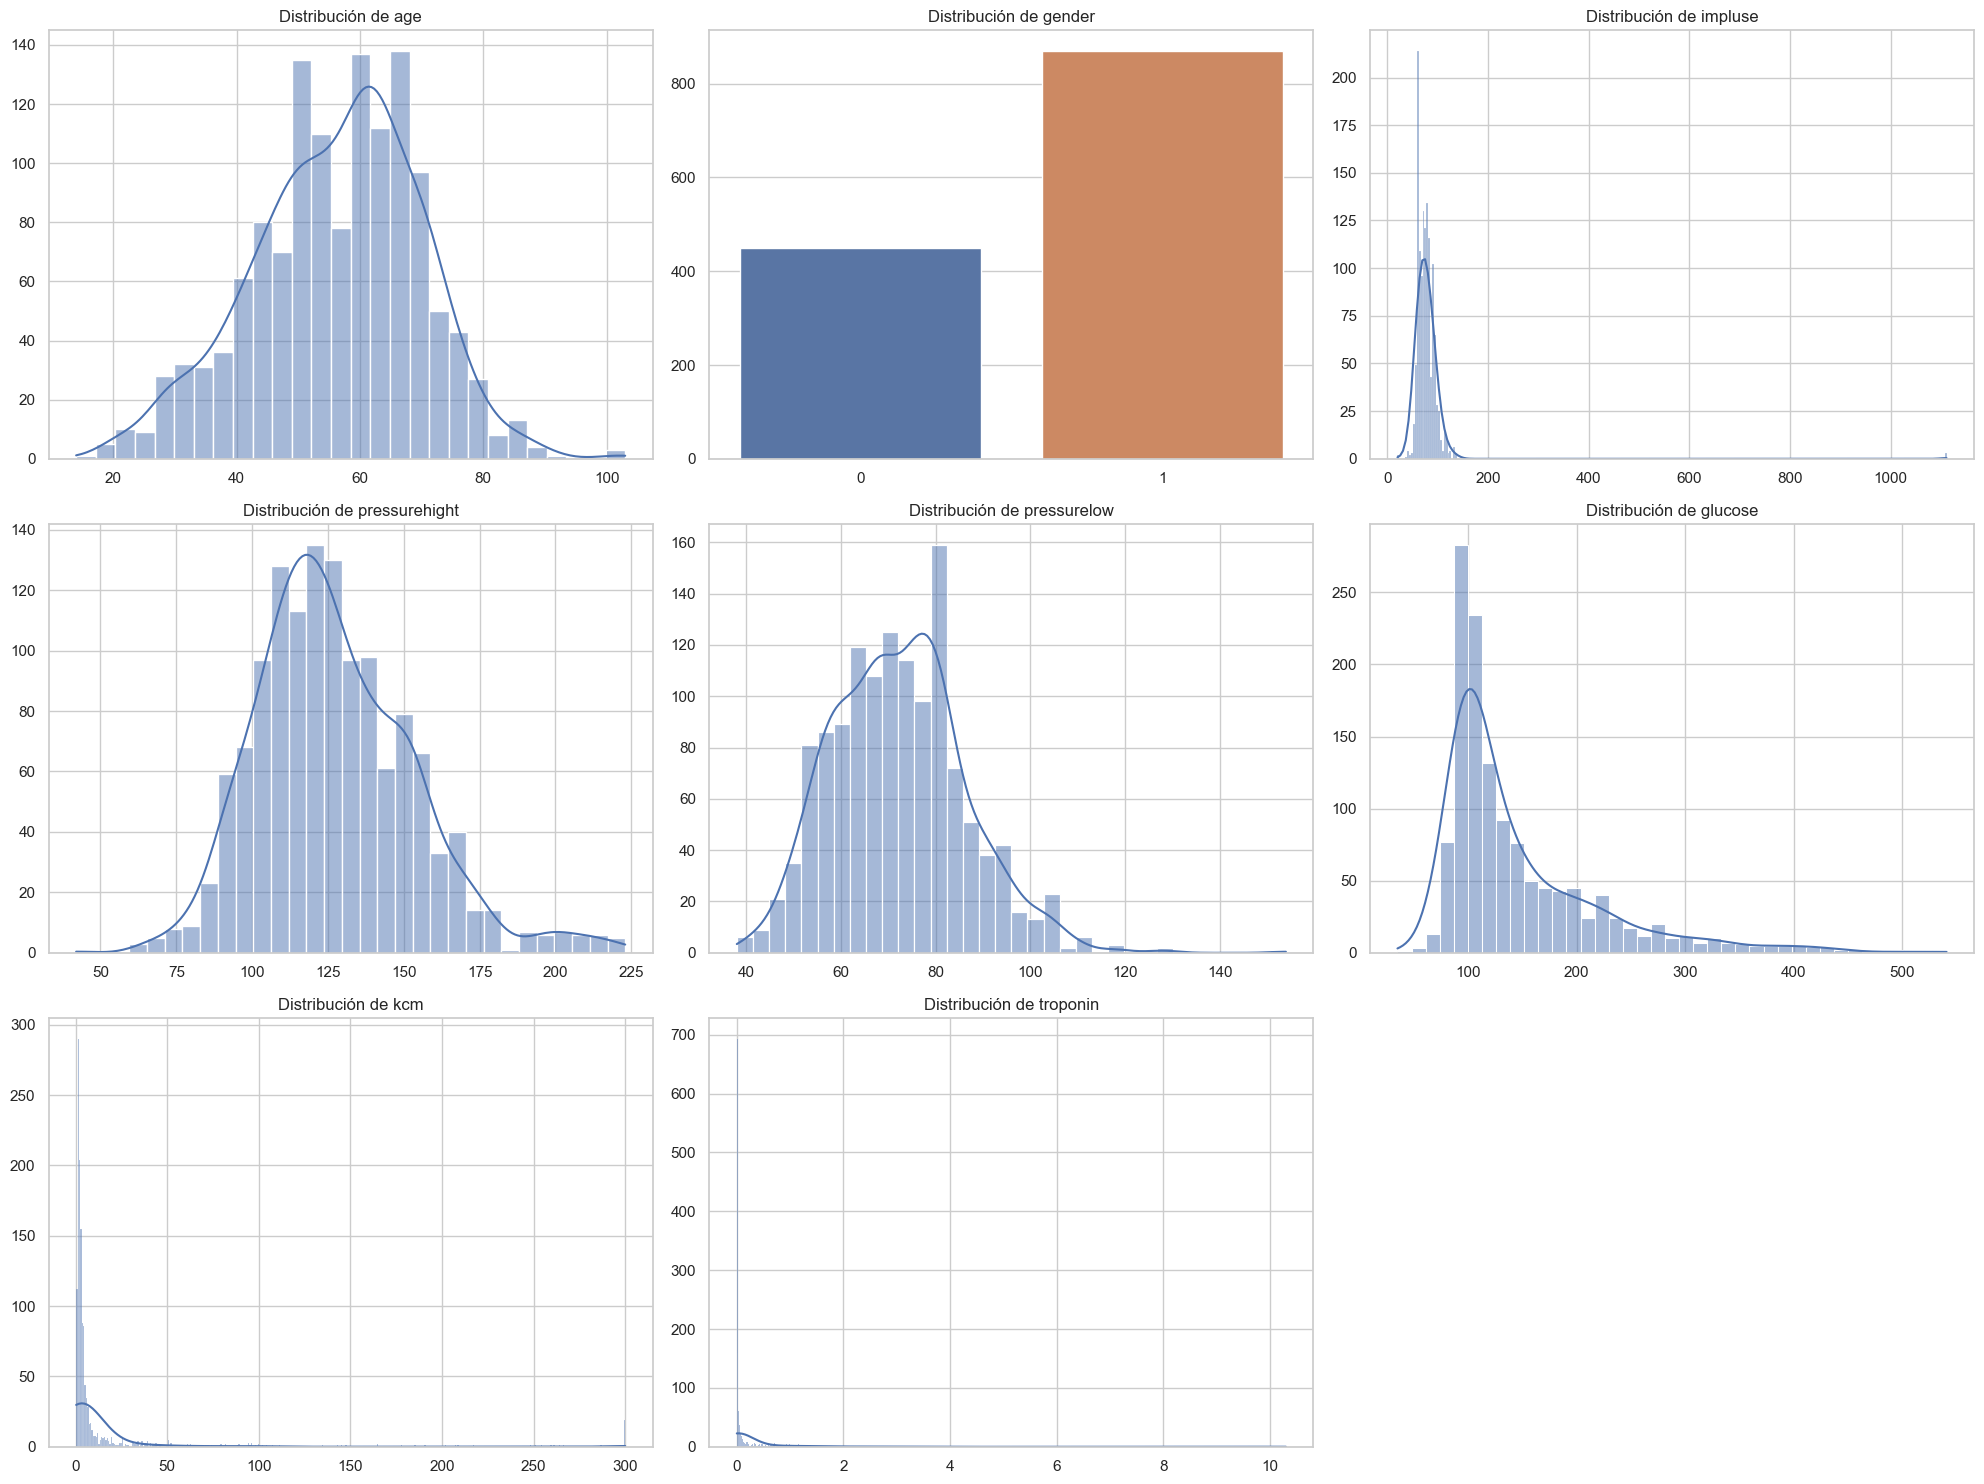

In [9]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 15))
dataplot = data.copy()
# Lista de las columnas a representar
columns = dataplot.columns.drop('class')

# Creamos un subplot para cada columna
for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    if dataplot[column].dtype == 'object' or column == 'gender':
        sns.countplot(x=column, data=data)
    else:
        sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

# Modelos de clasificación (sin tratamiento de outliers)

Para el análisis en tiempo real, se utilizaron dos modelos específicos para flujos de datos: el Adaptive Random Forest (ARF) y el Hoeffding Adaptive Tree Classifier. Estos modelos se caracterizan por su capacidad para adaptarse a flujos de datos dinámicos y detectar cambios o desviaciones en los datos a medida que se reciben.

Durante el entrenamiento, cada instancia del conjunto de datos se procesó de forma secuencial. Los modelos realizaron predicciones basadas en los datos actuales y, posteriormente, se actualizaron con la retroalimentación obtenida. Se monitoreó la precisión del modelo a lo largo del tiempo para detectar cualquier fluctuación o cambio significativo en su rendimiento.

Un aspecto clave a destacar es la detección de cambios en el flujo de datos. Si se detecta un cambio o "drift" en el flujo, es una señal de que el modelo puede no estar funcionando de manera óptima bajo las nuevas condiciones de los datos. En nuestro estudio, se empleó ADWIN como detector de cambios, y cuando se identificaba un "drift", se realizaban ajustes para adaptar el modelo al nuevo contexto de los datos.

Entrenando arf...
*** Warning: Drift detected at instance 223, reseteamos el modelo ***
*** Warning: Drift detected at instance 1119, reseteamos el modelo ***


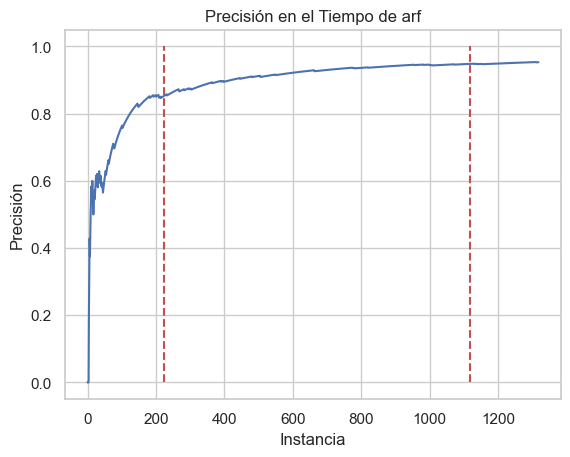

F1 Score: F1: 0.00%
MCC Score: MCC: 0.
Entrenando hoef...
*** Warning: Drift detected at instance 511, reseteamos el modelo ***


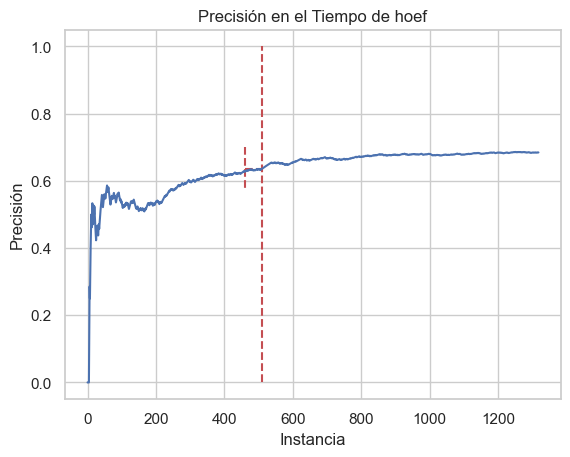

F1 Score: F1: 0.00%
MCC Score: MCC: 0.


In [13]:
modelos = {
        "arf": forest.ARFClassifier(drift_detector=ADWIN()),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN(), 
    drift_window_threshold=50,
    grace_period=20
)
    }

# Inicializar métricas
f1 = metrics.F1()
mcc = metrics.MCC()

for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
    y_preds = []
    y_trues = []
    print(f"Entrenando {nombre}...")
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        # Detección de outliers

        y_pred = modelo.predict_one(x)
        modelo.learn_one(x, y)
        y_trues.append(y)
        y_preds.append(y_pred)
        # Actualizar las métricas
        
        accuracy.update(y, y_pred)
        modelo.drift_detector.update(accuracy.get())

        if modelo.drift_detector.drift_detected:
            plt.vlines(i, 0, 1, colors='r', linestyles='dashed')
            try:
                plt.hlines(accuracy.get(), i-modelo.drift_window_threshold, i, colors='r', linestyles='dashed')
                plt.vlines(i-modelo.drift_window_threshold, accuracy.get()*1.1, accuracy.get()*0.9, colors='r', linestyles='dashed')
            except:
                pass
            print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
    
        accuracies.append(accuracy.get())

    f1.update(y_trues, y_preds)
    mcc.update(y_trues, y_preds)

    # Crear un gráfico de precisión en el tiempo
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

    # Calcular métricas finales
    print(f"F1 Score: {f1}")
    print(f"MCC Score: {mcc}")
    
   


Ambos modelos muestran un incremento en la precisión a medida que aumenta el número de instancias, pero a tasas y niveles diferentes.

Drift Detection
- En ambos gráficos, hay alertas de "Drift detected". Estas desviaciones pueden indicar cambios en la naturaleza de los datos o en la relación entre las variables, lo cual puede afectar el rendimiento del modelo. Es esencial abordar estos cambios para mantener la precisión del modelo.

Comparación entre modelos:
- El modelo ARF parece tener una mayor precisión general en comparación con "hoef", especialmente después de la instancia 800.
- El modelo HoeffdingTree parece estancarse en precisión después de la instancia 800, mientras que "arf" continúa mejorando levemente.

### MODELOS CON TRATAMIENTO DE OUTLIERS

*** Warning: Drift detected at instance 302, reseteamos el modelo ***
*** Warning: Drift detected at instance 1212, reseteamos el modelo ***


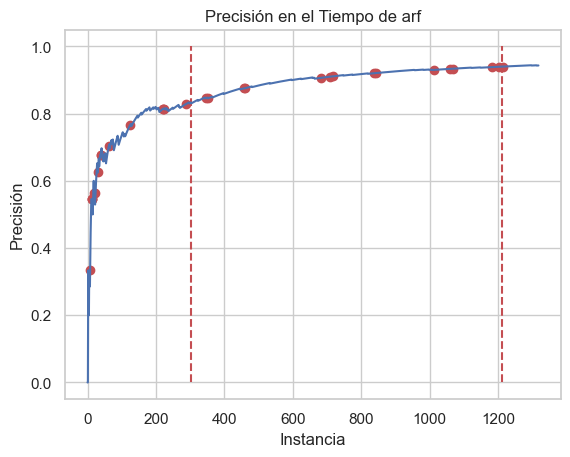

F1 Score: 0.00
MCC Score: 0.00
*** Warning: Drift detected at instance 302, reseteamos el modelo ***
*** Warning: Drift detected at instance 789, reseteamos el modelo ***


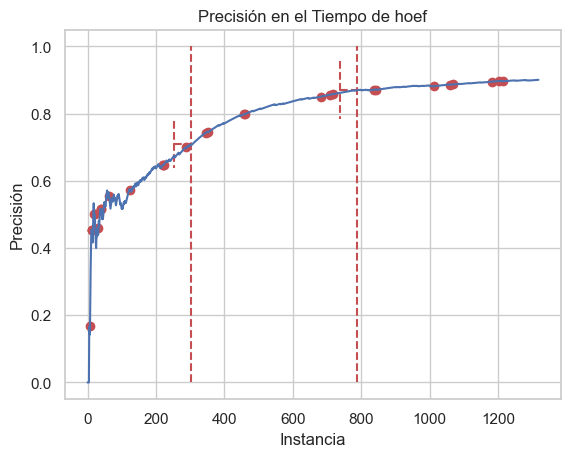

F1 Score: 0.00
MCC Score: 0.00


In [17]:
modelos = {
        "arf": forest.ARFClassifier(drift_detector=ADWIN()),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN(), 
    drift_window_threshold=50,
    grace_period=20
)
    }

# Inicializar métricas
f1 = metrics.F1()
mcc = metrics.MCC()

class IQR_Outlier_Detector:
    def __init__(self, factor=1.5):
        self.q1 = stats.Quantile(0.25)  # Primer cuartil
        self.q3 = stats.Quantile(0.75)  # Tercer cuartil
        self.factor = factor

    def update(self, value):
        self.q1.update(value)
        self.q3.update(value)

    def is_outlier(self, value):
        iqr = self.q3.get() - self.q1.get()
        lower_bound = self.q1.get() - self.factor * iqr
        upper_bound = self.q3.get() + self.factor * iqr

        return value < lower_bound or value > upper_bound

# Ejemplo de uso

    
for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
    detector = IQR_Outlier_Detector()
      
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        detector.update(x[2])
        # Detección de outliers
        is_outlier = detector.is_outlier(x[2])
        
        if is_outlier == 0:
            y_pred = modelo.predict_one(x)
            modelo.learn_one(x, y)
            
            # Actualizar las métricas
            f1.update(y, y_pred)
            mcc.update(y, y_pred)
            accuracy.update(y, y_pred)
            modelo.drift_detector.update(accuracy.get())
            if modelo.drift_detector.drift_detected:
                plt.vlines(i, 0, 1, colors='r', linestyles='dashed')
                try:
                    plt.hlines(accuracy.get(), i-modelo.drift_window_threshold, i, colors='r', linestyles='dashed')
                    plt.vlines(i-modelo.drift_window_threshold, accuracy.get()*1.1, accuracy.get()*0.9, colors='r', linestyles='dashed')
                except:
                    pass
                print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
        
        if is_outlier == 1:
            # print(f"Outlier detected at instance {i}")
            # print(f"valor de impulse: {x[2]} is an outlier!")
            plt.plot(i, accuracy.get(), 'ro')

    
        accuracies.append(accuracy.get())

 # Crear un gráfico de precisión en el tiempo
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

    # Calcular métricas finales
    print(f"F1 Score: {f1.get():.2f}")
    print(f"MCC Score: {mcc.get():.2f}")
    
   
